# Image classifier approach

This notebook describes my approach to image classification by some characteristics

## Features

### Color simmilarities

- Convert rgb values to light frequency
- plot values as curve to get color spectrum of the image
    - bin size for counting controls precision
- pick three highest peaks
- find image with the most similar peak values

### Feature similarities

- using ```cv.approxPolyDP()``` we find primitives in the image
    - [stackoverflow problem description](https://stackoverflow.com/questions/11424002/how-to-detect-simple-geometric-shapes-using-opencv)
- make list of primitives with type, average color, position and size
- compare with other images, turning on and off different similarity filters

## Similarity rating

Selecting the different aspects should give some normalized rating of how similar the images are.

## Addition
### Overall
I agree that adding different options that the user can turn on or off would make the system more flexible.

If we have time at the end, we could try building a GUI so the user can interact with these options.

It could also be useful to let the user adjust settings, like how many top colors to compare (e.g., top 1, 2, 3…), or choose between histogram-based or cluster-based approaches for color comparison.


### Some additions and thoughts:
- not sure if "light frequency" == HSV? 
- I would definetly use HSV
- we could cluster all HSV values using KMeans to find the main colors in the image. The resulting clusters would then contain both: color centers and their relative weight so that we can compare the overall color distribution in the images.



### To find similarities in where those colors are located in the image:
- we can add pixel coordinates as a feature in the KMeans clustering.
OR 
- a blurred version of the reference image and use it as a soft mask to compare how colors are spread out in the image. --> general idea of the color layout without focusing on exact color matches.
OR
- (I think you mentioned something like this before) split the image into a grid and calculate the main color for each section. -> low-resolution color map to compare with maps from other images.

In [16]:
# imports and path to images
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

dir = r"C:\Users\anton\OneDrive\Documents\HSD\sem4\DAISY_2025_images_for_bigdata"

### Loading Images with OpenCV and displaying them

In [53]:
def load_images_from_directory(directory):
    """
    Load all images from the specified directory using OpenCV.
    """
    images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            img = cv2.imread(filepath)
            if img is not None:
                images.append((filename, img))
    return images

def display_image(images, img_id=None):
    """
    Display a list of images using Matplotlib.
    """
    if img_id is None:
        img_id = random.randint(0, len(images) - 1)
    else:
        img_id = img_id
    filename, img = images[img_id]
    plt.figure()
    plt.title(filename)
    # Convert BGR to RGB for displaying with Matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    pass

def downscale_image(image, factor=0.01):
    """
    Downscale images by a specified factor.
    """
    filename, img = image
    height, width = img.shape[:2]
    new_size = (int(width * factor), int(height * factor))
    downscaled_img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    return (filename, downscaled_img)

def extract_dominant_colors(image, n_clusters=3):
    """
    Extract dominant colors from an image using KMeans clustering.
    Returns a n_clusters long list of rgb values 
    """
    # Unpack the tuple to get the filename and image
    filename, img = image
    
    # Convert the image to RGB (from BGR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Reshape the image to a 2D array of pixels where each row is a pixel and each column is a color channel
    pixels = img.reshape(-1, 3)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    
    # Get the cluster centers (dominant colors)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_
    cluster_sizes = np.bincount(labels)
    return (filename, dominant_colors, cluster_sizes)

def plot_dominant_colors(all_colors, img_id=None):
    """
    Gets tuple with label and dominant colors and plots them
    """
    if img_id is None:
        img_id = random.randint(0, len(all_colors) - 1)
    else:
        img_id = img_id
        
    filename, colors, cluster_sizes = all_colors[img_id]
    
    # Calculate percentages
    total_pixels = sum(cluster_sizes)
    percentages = (cluster_sizes / total_pixels) * 100
    
    # Create the plot
    plt.figure(figsize=(8, 2))
    plt.axis('off')
    plt.imshow([colors / 255])  # Normalize colors to [0, 1] for Matplotlib
    plt.title(filename)
    
    # Annotate with percentages
    for i, (color, percentage) in enumerate(zip(colors, percentages)):
        plt.text(
            x=i / len(colors) + 0.17,  # Position text slightly offset
            y=0.5,
            s=f"{percentage:.1f}%",
            color="white" if np.mean(color) < 128 else "black",  # Contrast text color
            fontsize=12,
            ha="center",
            va="center",
            transform=plt.gca().transAxes
        )
    
    plt.show()
    pass


### Clustering using KMeans

While clustering, I think it makes sense to choose attributes that have high value differences between images.

Because most images were taken using a smartphone, it makes little sense to choose `saturation` or `value` from `HSV`, because the automatic exposure and image post processing of smartphones ensures that these are similar across all images.


In [41]:
# Load and downscale images
images = load_images_from_directory(dir)

# downscale images
downscaled_images = []
for img in images:
    downscaled_images.append(downscale_image(img))
# print(f"Downscaled {len(images)} images")

# extract dominant colors for all images
all_dominant_colors = []
for img in downscaled_images:
    all_dominant_colors.append(extract_dominant_colors(img, n_clusters=3))
# print(all_dominant_colors[testing_id][0])

# normalized
all_dominant_colors_normalized = []
for dominant_colors in all_dominant_colors:
    normalized_colors = dominant_colors[1] / 255
    norm_label = dominant_colors[0]
    all_dominant_colors_normalized.append((normalized_colors, norm_label))
# print(all_dominant_colors_normalized[testing_id][0])

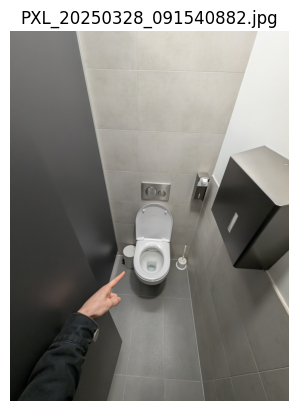

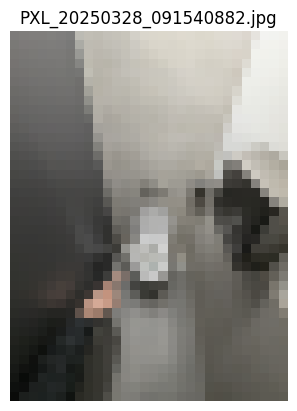

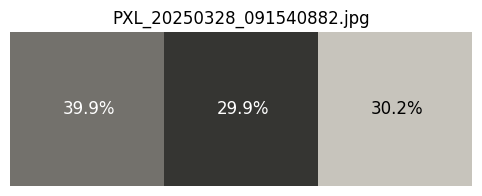

[[0.45098039 0.44313725 0.42352941]
 [0.20784314 0.20784314 0.19607843]
 [0.78039216 0.76862745 0.7372549 ]]


In [56]:
# Show progress of the workflow
testing_id = random.randint(0, len(images) - 1)

display_image(images, img_id=testing_id)
display_image(downscaled_images, img_id=testing_id)
plot_dominant_colors(all_dominant_colors, img_id=testing_id)
print(all_dominant_colors_normalized[testing_id][0])

### Categorizing according to color similarity

To compare the `3 x n` arrays (where each row represents a color in normalized RGB format), we'll look into using some of the following methods:

#### Euclidean Distance:
- Treat each color as a point in 3D space (R, G, B).
- Calculate the Euclidean distance between the colors. Smaller distances indicate higher similarity.

$$d = \sqrt{(R_1 - R_2)^2 + (G_1 - G_2)^2 + (B_1 - B_2)^2}$$
> source: [Wolfram MathWorld - distance](https://mathworld.wolfram.com/Distance.html)

Because we have multiple colors for each image we should compare the most dominant dominant of each respective image.


#### Cosine Similarity:
- Treat each color as a vector in 3D space.
- Compute the cosine of the angle between two vectors. A value closer to 1 indicates higher similarity.

#### Color Difference Metrics:
- Use perceptual color difference formulas like CIEDE2000 or CIE76, which account for how humans perceive color differences.

#### Cluster Matching:
- If comparing two sets of colors (e.g., two images), match the closest colors between the sets using a distance metric (e.g., Euclidean).
- Sum the distances for all matches to get an overall similarity score.

#### Weighted Comparison:
- Assign weights to the RGB channels based on their perceptual importance (e.g., green is more sensitive to the human eye).
- Use a weighted distance metric for comparison.

#### Thresholding:
- Define a threshold for similarity (e.g., a maximum allowable distance).
- If the distance between two colors is below the threshold, consider them similar.


By combining these methods, you can create a robust similarity measure for your use case.